In [1]:
from matplotlib import pyplot as plt
import cv2
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import torch
import torch.nn as nn
import torchvision
import numpy as np
from tqdm.notebook import tqdm

import pywt

import sys
sys.path.insert(0, '../research_pipelines/denoising_with_wavelets/')

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from DWT_IDWT.DWT_IDWT_layer import DWT_2D, IDWT_2D

%matplotlib inline

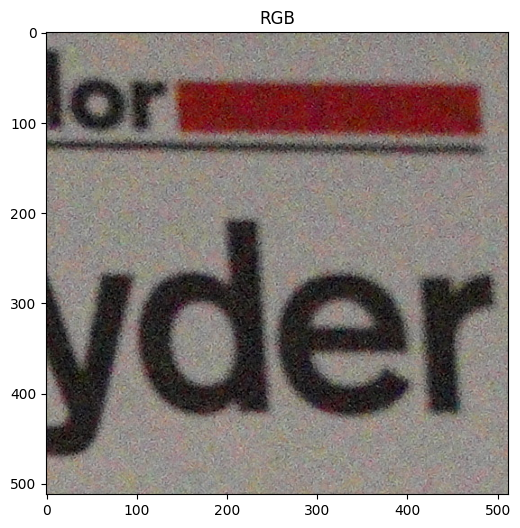

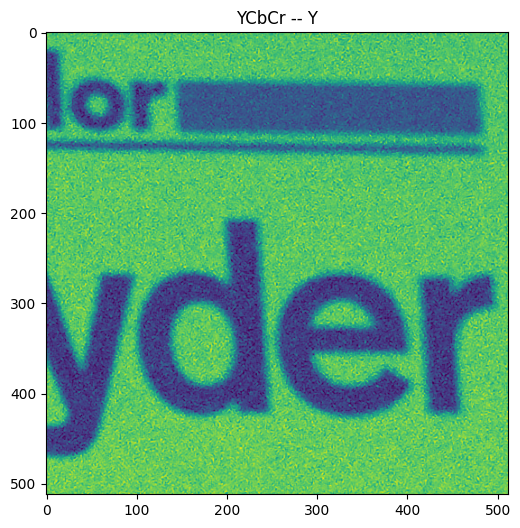

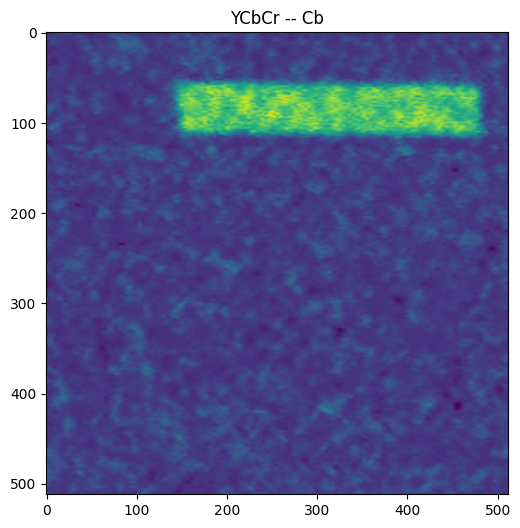

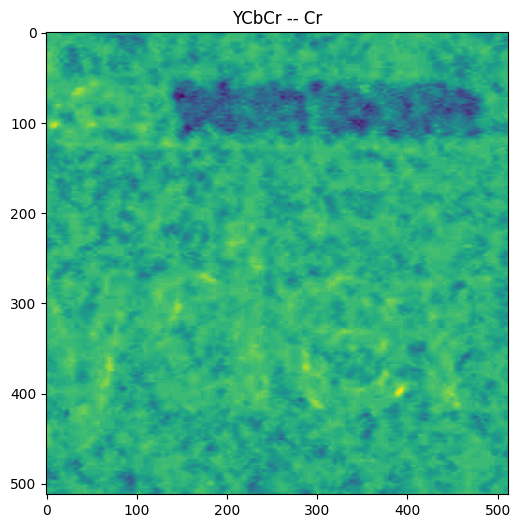

In [7]:
image_path = '../materials/sony_a7c_5_crop.png'
# image_path = '/home/alexey/Downloads/crop_noisy.png'
img = cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
# img = img[500:500+512, 500:500+512]

figsize=(6, 6)

plt.figure(figsize=figsize)
plt.title('RGB')
plt.imshow(img)

ycbcr_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

# for ch_to_blur in [1, 2]:
#     ycbcr_image[ch_to_blur] = cv2.GaussianBlur(ycbcr_image[ch_to_blur], (5, 5), 1)

for i, channel in zip([0, 1, 2], ['Y', 'Cb', 'Cr']):
    plt.figure(figsize=figsize)
    plt.title('YCbCr -- {}'.format(channel))
    plt.imshow(ycbcr_image[..., i])
    
# smoothed_rgb = cv2.cvtColor(ycbcr_image, cv2.COLOR_YCrCb2RGB)

# plt.figure(figsize=figsize)
# plt.title('RGB after YCbCr smothing with PSRN: {:.2f}'.format(cv2.PSNR(img, smoothed_rgb)))
# plt.imshow(smoothed_rgb)

plt.show()

3.5000000000000004 364.5000000000001
-65.0 88.0
-75.0 70.00000000000001
-36.00000000000001 32.00000000000001


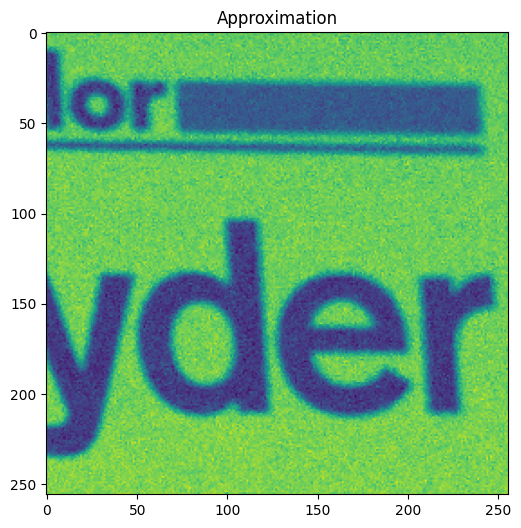

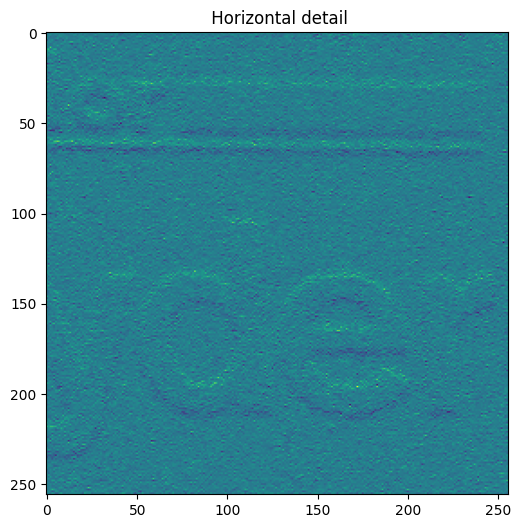

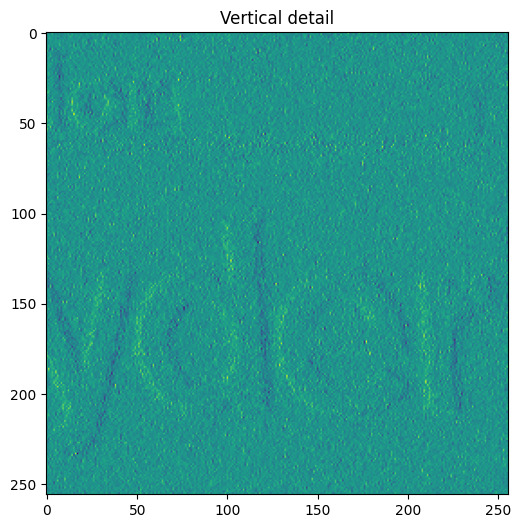

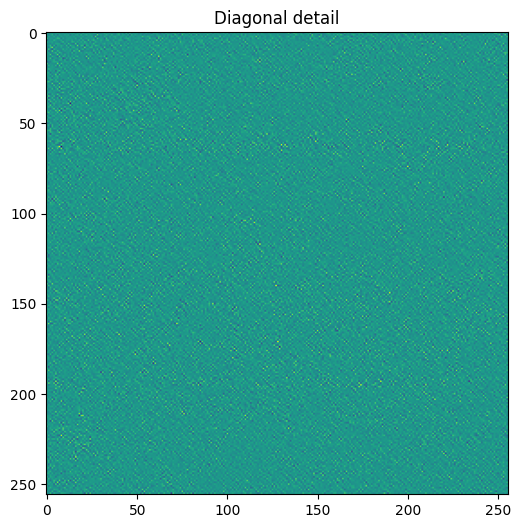

In [3]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

coeffs2 = pywt.dwt2(ycbcr_image[..., 0], 'haar')

LL, (LH, HL, HH) = coeffs2
for i, a in enumerate([LL, LH, HL, HH]):
    plt.figure(figsize=figsize)
    plt.title(titles[i])
    plt.imshow(a)
    print(a.min(), a.max())

plt.show()

In [4]:
dwt = DWT_2D('haar')
iwt = IDWT_2D('haar')
device = 'cpu'

torch.Size([1, 3, 256, 256])
tensor(0.) tensor(1.5549)
tensor(-0.2980) tensor(0.2745)
tensor(-0.2549) tensor(0.3451)
tensor(-0.1431) tensor(0.1255)
PSNR: 50.31724


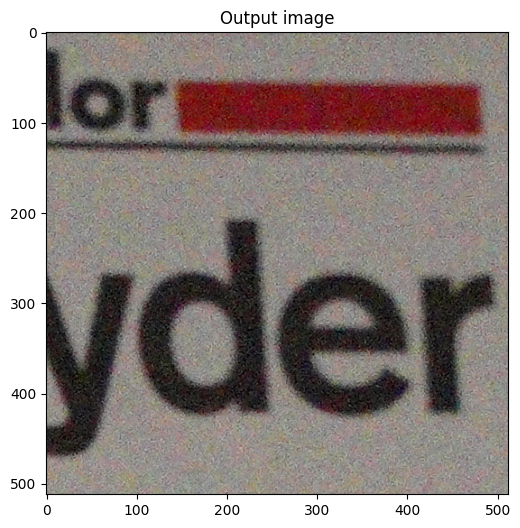

In [6]:
img_tensor = torch.from_numpy(img.astype(np.float32).transpose(2, 0, 1) / 255.0).unsqueeze(0)
gt_ll, gt_lh, gt_hl, gt_hh = dwt(img_tensor.to(device))

print(gt_lh.shape)

for elem in (gt_ll, gt_lh, gt_hl, gt_hh):
    print(elem.min(), elem.max())

reversed_image = iwt(gt_ll, gt_lh, gt_hl, gt_hh).to('cpu').numpy()
reversed_image = (reversed_image * 255.0).astype(np.uint8)[0].transpose(1, 2, 0)

plt.figure(figsize=figsize)
plt.title('Output image')
plt.imshow(reversed_image)

print('PSNR: {:.5f}'.format(cv2.PSNR(img, reversed_image)))

plt.show()